ModuleNotFoundError: No module named 'google.colab'

In [2]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from PIL import Image
from tqdm import tqdm
from tqdm.notebook import tqdm
import seaborn as sns


from sklearn.metrics import confusion_matrix
from sklearn import model_selection

import torch
import torchvision.models as models
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision.transforms import transforms
from torchvision.utils import make_grid
import torch.nn.functional as F

ModuleNotFoundError: No module named 'torch'

In [3]:
pip install torch

     -------------------------------------- 159.7/159.7 MB 3.4 MB/s eta 0:00:00
     -------------------------------------- 228.5/228.5 MB 2.9 MB/s eta 0:00:00
     ---------------------------------------- 3.5/3.5 MB 22.5 MB/s eta 0:00:00
     ------------------------------------- 286.4/286.4 kB 17.3 MB/s eta 0:00:00
  Attempting uninstall: tbb
    Found existing installation: TBB 0.2
Note: you may need to restart the kernel to use updated packages.


ERROR: Cannot uninstall 'TBB'. It is a distutils installed project and thus we cannot accurately determine which files belong to it which would lead to only a partial uninstall.


In [ ]:
ROOT_PATH = '/content/drive/My Drive/ML_Project'
BASE_PATH = os.path.join(ROOT_PATH, 'EuroSAT_RGB')
#BASE_PATH = ROOT_PATH
DATA_PATH = os.path.join(ROOT_PATH, 'EuroSAT_MS')
FULL_DATA_DF = os.path.join(ROOT_PATH, 'FULL_DATA.csv')

if not os.path.isdir(DATA_PATH):
    os.mkdir(DATA_PATH)

IDX_CLASS_LABELS = {
    0: 'AnnualCrop',
    1: 'Forest',
    2: 'HerbaceousVegetation',
    3: 'Highway',
    4: 'Industrial',
    5: 'Pasture',
    6: 'PermanentCrop',
    7: 'Residential',
    8: 'River',
    9: 'SeaLake'
}
CLASSES = ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture','PermanentCrop','Residential','River', 'SeaLake']
CLASS_IDX_LABELS = dict()
for key, val in IDX_CLASS_LABELS.items():
  CLASS_IDX_LABELS[val] = key

NUM_CLASSES = len(IDX_CLASS_LABELS.items())
torch.manual_seed(10)
VALID_SIZE = 0.1

In [ ]:
## Give idx of each class name
def encode_label(label):
    idx = CLASS_IDX_LABELS[label]
    return idx

## Take in idx and return the class name
def decode_target(target, text_labels=True):
    result = []
    if text_labels:
        return IDX_CLASS_LABELS[target]
    else:
        return target

## Show batches of images
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(16, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break

In [ ]:
print(encode_label('Forest'), decode_target(1))
print(decode_target(2, text_labels=True))

1 Forest
HerbaceousVegetation


In [ ]:
from os import walk
i = 0
for (dirpath, dirname, filename) in walk(BASE_PATH):
  print("Directory Path: ", dirpath)
  print("Directory Name: ", dirname)
  print("Filename : ", filename)
  print("----------------------"*10)
  i += 1
  if i > 3:
    break

Directory Path:  /content/drive/My Drive/ML_Project/EuroSAT_RGB
Directory Name:  ['River', 'AnnualCrop', 'Residential', 'Pasture', 'PermanentCrop', 'Industrial', 'Highway', 'SeaLake', 'Forest', 'HerbaceousVegetation']
Filename :  []
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


KeyboardInterrupt: 

In [ ]:
from os import walk

i = 0
DATA_DF = pd.DataFrame(columns = ['image_id', 'label'])

for (dirpath, dirname, filename) in walk(BASE_PATH):
  for each_file in filename:
    DATA_DF.loc[i] = [each_file, dirpath.split('/')[-1]]
    i += 1
  # break
DATA_DF.to_csv(FULL_DATA_DF, index=False)
DATA_DF.head()


,image_id,label
0,River_1556.jpg,River
1,River_2022.jpg,River
2,River_967.jpg,River
3,River_396.jpg,River
4,River_892.jpg,River


In [ ]:
DATA_DF = pd.read_csv(FULL_DATA_DF)
DATA_DF = DATA_DF.sample(frac = 1, random_state=48)
TRAIN_DF = DATA_DF[:-int(len(DATA_DF)*VALID_SIZE)]
VALID_DF = DATA_DF[-int(len(DATA_DF)*VALID_SIZE) :]

In [ ]:
TRAIN_DF.reset_index(inplace = True)
TRAIN_DF.head()

,index,image_id,label
0,22417,Forest_2841.jpg,Forest
1,5105,AnnualCrop_2271.jpg,AnnualCrop
2,7884,Residential_2748.jpg,Residential
3,5906,Residential_1464.jpg,Residential
4,6553,Residential_343.jpg,Residential


In [ ]:
VALID_DF.reset_index(inplace = True)
VALID_DF.head()

,index,image_id,label
0,25629,HerbaceousVegetation_971.jpg,HerbaceousVegetation
1,21573,Forest_2010.jpg,Forest
2,26838,HerbaceousVegetation_2685.jpg,HerbaceousVegetation
3,13947,Industrial_623.jpg,Industrial
4,14994,Industrial_1635.jpg,Industrial


In [ ]:
TRAIN_DF.size, VALID_DF.size

(72927, 8103)

In [ ]:
class EuroSAT(Dataset):
    def __init__(self, train_df, train_dir, transform=None):
        self.train_dir = train_dir
        self.train_df = train_df
        self.transform = transform

    def __len__(self):
        return len(self.train_df)

    def __getitem__(self, idx):
        row = self.train_df.loc[idx]
        img_id, label = row['image_id'], row['label']
        img = Image.open(os.path.join(self.train_dir, img_id.split('.')[0].split('_')[0], img_id))
        if self.transform:
            img = self.transform(img)
        return img, encode_label(label)

In [ ]:
## Dataset and transformations
data_transform = transforms.Compose([
                                transforms.Resize(size=(224, 224)),
#                                 transforms.CenterCrop(224),
                                transforms.ToTensor(),
                                # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                ])
train_ds = EuroSAT(TRAIN_DF, BASE_PATH, data_transform)
valid_ds = EuroSAT(VALID_DF, BASE_PATH, data_transform)
print(len(train_ds), len(valid_ds))

24309 2701


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


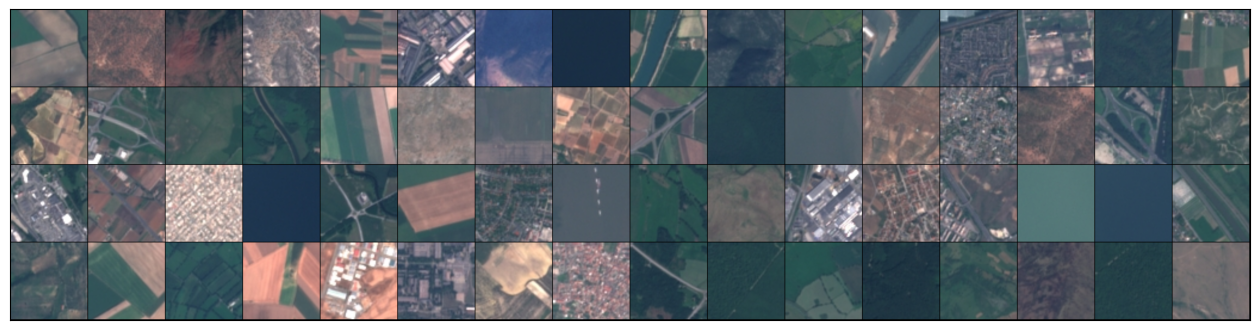

In [ ]:
batch_size = 64
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
valid_dl = DataLoader(valid_ds, batch_size, shuffle=False, num_workers=2, pin_memory=True)
show_batch(train_dl)

In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim = 1)
    return torch.tensor(torch.sum(preds==labels).item() / len(preds))

class MulticlassClassifierBase(nn.Module):

    def training_step(self, batch):
        img, label = batch
        out = self(img)
        loss = criterion(out, label)
        accu = accuracy(out, label)
        return accu ,loss
    def validation_step(self, batch):
        img, label = batch
        out = self(img)
        loss = criterion(out, label)
        accu = accuracy(out, label)
        return {"val_loss": loss.detach(), "val_acc": accu}

    def validation_epoch_ends(self, outputs):
        batch_loss = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_loss).mean()
        batch_acc = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_acc).mean()
        return {"val_loss":epoch_loss.item(), "val_acc":epoch_acc.item()}
    def epoch_end(self, epoch, result):
        print("Epoch [{}],train_accu: {:.4f}, learning_rate: {:.4f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch,result['train_accu'], result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

In [ ]:
class LULC_Model(MulticlassClassifierBase):
    def __init__(self):
        super().__init__()
        self.network = models.wide_resnet50_2(pretrained=True)
        n_inputs = self.network.fc.in_features
        print("in_fet: ",n_inputs)
        self.network.fc = nn.Sequential(
                              nn.Linear(n_inputs, 256),
                              nn.ReLU(),
                              nn.Dropout(0.5),
                              nn.Linear(256, NUM_CLASSES),
                              nn.LogSoftmax(dim=1)
                                )
    def forward(self, xb):
        return self.network(xb)

    def freeze(self):
        for param in self.network.parameters():
            param.require_grad=False
        for param in self.network.fc.parameters():
            param.require_grad=True
    def unfreeze(self):
        for param in self.network.parameters():
            param.require_grad=True

In [ ]:
model = LULC_Model()

in_fet:  2048


In [ ]:
## Running through the data loader => Model => Output
def try_batch(dl):
    for images, labels in dl:
        print(images.shape)
        out = model(images)
        print(out.shape)
        print(out[0])
        break
try_batch(train_dl)

torch.Size([64, 3, 224, 224])
torch.Size([64, 10])
tensor([-2.3210, -2.3247, -2.2982, -2.2229, -2.3324, -2.0784, -2.2918, -2.5281,
        -2.3567, -2.3285], grad_fn=<SelectBackward0>)


In [ ]:
@torch.no_grad()
def evaluate(model, valid_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in valid_loader]
    return model.validation_epoch_ends(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit(epochs, max_lr,  model, train_loader, valid_loader, weight_decay=0,\
                grad_clip=None,opt_func=torch.optim.SGD, max_epochs_stop=3):

    history = []
    valid_loss_min = np.Inf
    valid_acc_max = 0
    model_file_name = 'lulc.pth'
    model_file_name2 = 'lulc_max_acc.pth'
    epochs_no_improve =  0
    optimizer = opt_func(model.parameters(), lr=max_lr, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2, factor=0.00001)

    for epoch in range(epochs):
        model.train()
        train_loss = []
        train_accu = []
        lrs = []
        for batch in tqdm(train_loader):

            accu, loss = model.training_step(batch)
            train_loss.append(loss)
            train_accu.append(accu)
            loss.backward()
            ## Gradient Clipping
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            optimizer.step()
            optimizer.zero_grad()

            lrs.append(get_lr(optimizer))



        result = evaluate(model, valid_loader)
        scheduler.step(result['val_loss'])
        ########### Early Stopping ##############
        valid_loss = result['val_loss']
        valid_acc = result['val_acc']
        if valid_acc > valid_acc_max:
            torch.save(model.state_dict(), model_file_name2)
            valid_acc_max = valid_acc
        if valid_loss<valid_loss_min:
            torch.save(model.state_dict(), model_file_name)
            valid_loss_min = valid_loss
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve > max_epochs_stop:
                result["train_loss"] = torch.stack(train_loss).mean().item()
                result["train_accu"] = torch.stack(train_accu).mean().item()
                result["lrs"] = lrs
                model.epoch_end(epoch, result)
                history.append(result)
                print("Early Stopping............................")
                return history

        result["train_loss"] = torch.stack(train_loss).mean().item()
        result["train_accu"] = torch.stack(train_accu).mean().item()
        result["lrs"] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    print("VAL LOSS MIN {}".format(valid_loss_min))
    print("VAL ACC MAX {}".format(valid_acc_max))
    return history

In [ ]:
def get_device():
    print(torch.cuda.is_available())
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)

In [ ]:
device = get_device()
## Loading data to devide
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)
## Loading model to device
model = to_device(LULC_Model(), device)
## lets try passing a batch to model again
try_batch(train_dl)

True
torch.Size([64, 3, 224, 224])
torch.Size([64, 10])
tensor([-2.4028, -2.2568, -2.1276, -2.1819, -2.3421, -2.2369, -2.5412, -2.2870,
        -2.5455, -2.1963], device='cuda:0', grad_fn=<SelectBackward0>)


In [ ]:
torch.cuda.empty_cache()

In [ ]:
## Hyper Parameters
max_epochs_stop = 10
max_lr = 1e-4
grad_clip = 0.1
weight_decay = 1e-3
batch_size = 64
criterion = nn.CrossEntropyLoss()
epochs = 10
opt_func = torch.optim.Adam
## Evaluating with non-trained model
evaluate(model, valid_dl)

{'val_loss': 2.30373477935791, 'val_acc': 0.10062612593173981}

In [1]:

model.freeze()
## Training
history = fit(epochs, max_lr, model, train_dl, valid_dl, weight_decay, grad_clip, opt_func, max_epochs_stop)

NameError: name 'model' is not defined